In [ ]:
#chargement des bibliothéques
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
import zipfile
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
#extraction des datsets
zip_path = "/content/drive/MyDrive/fake&real news/WELFake_Dataset.csv.zip"
extract_path = "/content/data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Extraction terminée ✅")


Extraction terminée ✅


In [ ]:
df1=pd.read_csv("/content/data/WELFake_Dataset.csv")
print(df1.head())
df2=pd.read_csv("/content/drive/MyDrive/fake&real news/data_snopes_real_fake.csv")
print(df2.head())
print(df1.shape)
print(df2.shape)

   Unnamed: 0                                              title  \
0           0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1           1                                                NaN   
2           2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3           3  Bobby Jindal, raised Hindu, uses story of Chri...   
4           4  SATAN 2: Russia unvelis an image of its terrif...   

                                                text  label  
0  No comment is expected from Barack Obama Membe...      1  
1     Did they post their votes for Hillary already?      1  
2   Now, most of the demonstrators gathered last ...      1  
3  A dozen politically active pastors came here f...      0  
4  The RS-28 Sarmat missile, dubbed Satan 2, will...      1  
                                               TEXTE LABEL          SOURCE  \
0  TITLE: \nCLAIM: Singer Barbra Streisand sang "...  FAKE  Snopes_Scraped   
1  TITLE: \nCLAIM: On Sept. 3, 2025, U.S. Preside...  FAKE  Sno

In [ ]:
#dataset 1
#gestion des nan
df1['title'] = df1['title'].fillna('')
# fusion des deux colonnes titre et text
df1['full_text'] = df1['title'] + " [SEP] " + df1['text']
#ajout d'une colonne soucre pour faire la distiction
df1['SOURCE'] = 'Kaggle_External'
df_kaggle = df1[['full_text', 'label', 'SOURCE']] # filtrage des colonnes
print("\n Kaggle : Combinaison du titre et du texte effectué.")
print(df_kaggle.head())



 Kaggle : Combinaison du titre et du texte effectué.
                                           full_text  label           SOURCE
0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...      1  Kaggle_External
1   [SEP] Did they post their votes for Hillary a...      1  Kaggle_External
2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...      1  Kaggle_External
3  Bobby Jindal, raised Hindu, uses story of Chri...      0  Kaggle_External
4  SATAN 2: Russia unvelis an image of its terrif...      1  Kaggle_External


In [ ]:
# nettoyage des dtasets
#datset2
#Standardisation du label
df2['label'] = df2['LABEL'].apply(lambda x: 0 if x == 'FAKE' else 1)
# Nettoyage initial : Suppression des préfixes "TITLE: \nCLAIM:"
df2['full_text'] = df2['TEXTE'].apply(lambda x: re.sub(r'TITLE: \nCLAIM: ', '', str(x), flags=re.IGNORECASE))
df_snopes = df2[['full_text', 'label', 'SOURCE']] # Garder seulement les colonnes utiles
print("✅ Snopes : Harmonisation des labels et nettoyage des préfixes effectué.")
print(df_snopes.head())


✅ Snopes : Harmonisation des labels et nettoyage des préfixes effectué.
                                           full_text  label          SOURCE
0  Singer Barbra Streisand sang "God Bless Americ...      0  Snopes_Scraped
1  On Sept. 3, 2025, U.S. President Donald Trump ...      0  Snopes_Scraped
2  In October 2025, a study showed that COVID-19 ...      1  Snopes_Scraped
3  A mountain lion broke into a Colorado Springs,...      0  Snopes_Scraped
4  In November 2025, a 91-year-old woman was arre...      0  Snopes_Scraped


In [ ]:
#combinaison des datasets
df_combined = pd.concat([df_snopes, df_kaggle], ignore_index=True)
print(f"\n Fusion terminée. Taille totale du dataset : {len(df_combined)} lignes.")


 Fusion terminée. Taille totale du dataset : 72496 lignes.


In [ ]:
# prétraitement du texte
# nettoyage suppression des ponctuations, baliss html(peu probable)etc.
def clean_html_and_non_alpha(text):
    text = str(text)
    # Suppression du HTML
    text = re.sub(r'<[^>]+>', '', text)
    # Conversion en minuscules
    text = text.lower()
    # Suppression des caractères non-alphabétiques/espaces (conserver le séparateur [sep])
    text = re.sub(r'[^\w\s\[\]]', '', text)
    return text

df_combined['cleaned_text'] = df_combined['full_text'].apply(clean_html_and_non_alpha)

print("\n--- Aperçu après le premier nettoyage ---")
print(df_combined[['full_text', 'cleaned_text', 'label']].tail())


--- Aperçu après le premier nettoyage ---
                                               full_text  \
72491  Russians steal research on Trump in hack of U....   
72492   WATCH: Giuliani Demands That Democrats Apolog...   
72493  Migrants Refuse To Leave Train At Refugee Camp...   
72494  Trump tussle gives unpopular Mexican leader mu...   
72495  Goldman Sachs Endorses Hillary Clinton For Pre...   

                                            cleaned_text  label  
72491  russians steal research on trump in hack of us...      0  
72492   watch giuliani demands that democrats apologi...      1  
72493  migrants refuse to leave train at refugee camp...      0  
72494  trump tussle gives unpopular mexican leader mu...      0  
72495  goldman sachs endorses hillary clinton for pre...      1  


In [ ]:
#prétraitement
#une seule fonction pour la tokenisation , la suppression des stop words et la lemmatisation
STOP_WORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
# --- Mise à Jour des Stopwords pour les Problèmes Spécifiques ---
# Ajout des termes problématiques ('mr', 'u') et de l'artefact '[sep]' pour une double sécurité
custom_removals = {
    'mr', 'u', 'sep',
    '[sep]', # S'assurer que le séparateur est retiré
    # Tous les mots d'une seule lettre (pour le problème de 'u')
    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
    'n', 'o', 'p', 'q', 'r', 's', 't', 'v', 'w', 'x', 'y', 'z'
}
STOP_WORDS.update(custom_removals)

# --- Fonction de Prétraitement Finalisée ---
def nlp_preprocess_final_V2(text):
    if pd.isna(text) or text is None:
        return []

    tokens = nltk.word_tokenize(str(text).strip()) # Utilisation de .strip() pour les espaces
    filtered_tokens = []

    for word in tokens:
        word = word.strip() # Nettoyage des espaces invisibles/non-standard

        # 1. Stopword (inclut maintenant 'mr', 'u', et '[sep]' grâce à l'update)
        if word in STOP_WORDS:
            continue

        # 2. Numérique
        if word.isdigit():
            continue

        # 3. Longueur (Même après la suppression des lettres uniques, pour plus de sûreté)
        if len(word) <= 1:
            continue

        # 4. Lemmatisation
        lemmas = lemmatizer.lemmatize(word)
        filtered_tokens.append(lemmas)

    return filtered_tokens

# --- Application de la correction ---
# La colonne 'cleaned_text' est l'input la plus propre avant cette phase
df_combined['tokens_final_V2'] = df_combined['cleaned_text'].apply(nlp_preprocess_final_V2)
df_combined['final_text_vf'] = df_combined['tokens_final_V2'].apply(lambda x: ' '.join(x))


print("✅ Correction des stopwords ('u', 'mr', '[sep]') appliquée.")
print("\n--- Aperçu du résultat CORRIGÉ FINAL (V2) ---")
print(df_combined[['cleaned_text', 'final_text_vf']].head())

✅ Correction des stopwords ('u', 'mr', '[sep]') appliquée.

--- Aperçu du résultat CORRIGÉ FINAL (V2) ---
                                        cleaned_text  \
0  singer barbra streisand sang god bless america...   
1  on sept 3 2025 us president donald trump order...   
2  in october 2025 a study showed that covid19 mr...   
3  a mountain lion broke into a colorado springs ...   
4  in november 2025 a 91yearold woman was arreste...   

                                       final_text_vf  
0  singer barbra streisand sang god bless america...  
1  sept u president donald trump ordered military...  
2  october study showed covid19 mrna vaccine help...  
3  mountain lion broke colorado spring colorado p...  
4  november 91yearold woman arrested stealing hus...  


In [ ]:
#visualisation *
#chargement des bibliothéques necessaires
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
!pip install wordcloud
from wordcloud import WordCloud


--- Statistiques Descriptives de la Longueur des Textes ---
Statistiques Générales (Toutes Classes) :
count    72496.000000
mean       308.480440
std        341.869413
min          0.000000
25%        136.000000
50%        232.000000
75%        383.000000
max      18361.000000
Name: text_length, dtype: float64

Statistiques par Classe (0: FAKE, 1: REAL) :
         count        mean         std  min    25%    50%    75%      max
label                                                                    
0      35242.0  331.499177  302.599900  4.0  145.0  257.0  450.0   7652.0
1      37254.0  286.704891  373.956576  0.0  130.0  211.0  321.0  18361.0


/tmp/ipython-input-1731541910.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='text_length', data=df_combined, palette={'0': 'red', '1': 'green'})


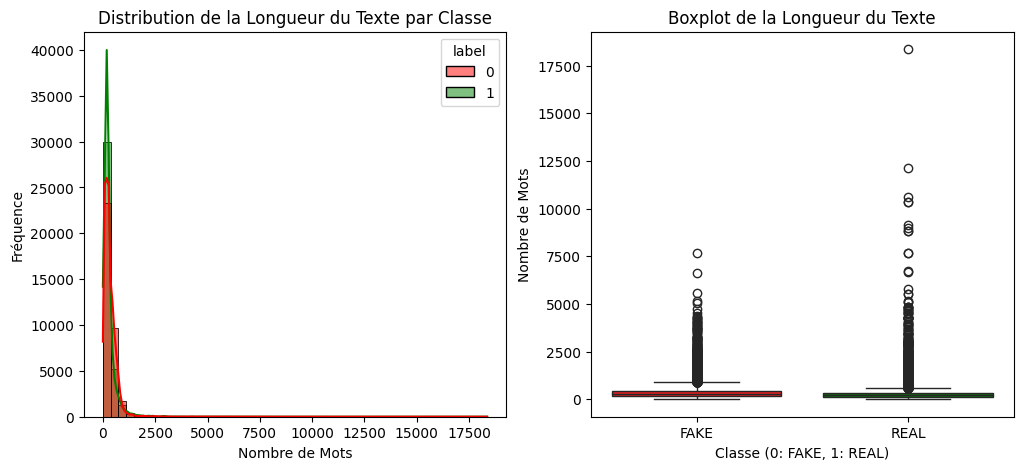

In [ ]:

# 1. Création de la colonne de longueur de texte (basée sur le nombre de mots nettoyés)
# Nous utilisons la colonne 'tokens_lemmatized_corrected'
df_combined['text_length'] = df_combined['tokens_final_V2'].apply(len)

print("\n--- Statistiques Descriptives de la Longueur des Textes ---")
print("Statistiques Générales (Toutes Classes) :")
print(df_combined['text_length'].describe())

# 2. Statistiques par Classe
print("\nStatistiques par Classe (0: FAKE, 1: REAL) :")
print(df_combined.groupby('label')['text_length'].describe())

# 3. Visualisation de la Distribution

# Histogramme de la longueur du texte
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(data=df_combined, x='text_length', hue='label', bins=50, kde=True, palette={0: 'red', 1: 'green'})
plt.title('Distribution de la Longueur du Texte par Classe')
plt.xlabel('Nombre de Mots')
plt.ylabel('Fréquence')

# Boxplot pour comparer les médianes et les quartiles
plt.subplot(1, 2, 2)
sns.boxplot(x='label', y='text_length', data=df_combined, palette={'0': 'red', '1': 'green'})
plt.title('Boxplot de la Longueur du Texte')
plt.xlabel('Classe (0: FAKE, 1: REAL)')
plt.ylabel('Nombre de Mots')
plt.xticks([0, 1], ['FAKE', 'REAL'])
plt.show()


--- 20 Mots les Plus Fréquents pour la classe FAKE (0) ---
[('said', 184640), ('trump', 115062), ('state', 70116), ('would', 62672), ('u', 56850), ('president', 51514), ('new', 50079), ('year', 46015), ('one', 43629), ('people', 42153), ('republican', 40252), ('time', 38697), ('also', 36626), ('government', 31842), ('house', 31181), ('clinton', 30230), ('could', 30135), ('say', 28990), ('reuters', 28813), ('united', 27792)]

--- 20 Mots les Plus Fréquents pour la classe REAL (1) ---
[('trump', 110834), ('u', 50952), ('people', 49129), ('clinton', 48119), ('said', 47151), ('one', 46005), ('would', 43140), ('state', 42832), ('president', 38214), ('hillary', 34433), ('time', 34315), ('like', 32289), ('american', 30578), ('new', 29438), ('year', 29282), ('also', 28370), ('obama', 28202), ('even', 25588), ('donald', 25511), ('say', 25506)]


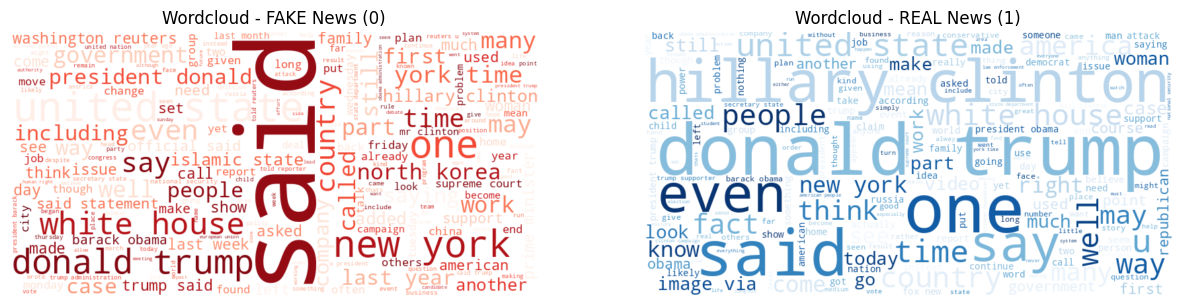

In [ ]:


# 1. Séparer le texte par classe (en utilisant la colonne 'final_text_corrected')
fake_news_text = " ".join(df_combined[df_combined['label'] == 0]['final_text_vf'].tolist())
real_news_text = " ".join(df_combined[df_combined['label'] == 1]['final_text_vf'].tolist())

# 2. Analyse des 20 mots les plus fréquents pour la classe FAKE
fake_tokens = fake_news_text.split()
fake_word_freq = Counter(fake_tokens)
top_20_fake = fake_word_freq.most_common(20)

# 3. Analyse des 20 mots les plus fréquents pour la classe REAL
real_tokens = real_news_text.split()
real_word_freq = Counter(real_tokens)
top_20_real = real_word_freq.most_common(20)

# --- Affichage des Fréquences ---
print("\n--- 20 Mots les Plus Fréquents pour la classe FAKE (0) ---")
print(top_20_fake)
print("\n--- 20 Mots les Plus Fréquents pour la classe REAL (1) ---")
print(top_20_real)

# --- Visualisation Wordcloud ---
plt.figure(figsize=(15, 6))

# Wordcloud FAKE News
plt.subplot(1, 2, 1)
wordcloud_fake = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(fake_news_text)
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis("off")
plt.title('Wordcloud - FAKE News (0)')


# Wordcloud REAL News
plt.subplot(1, 2, 2)
wordcloud_real = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate(real_news_text)
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.axis("off")
plt.title('Wordcloud - REAL News (1)')


plt.show()

In [ ]:
#chargement des bibliothéques pour la vectorisation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import pandas as pd

# Colonne de texte FINALEMENT nettoyé
TEXT_DATA_V2 = df_combined['final_text_vf']
TARGET = df_combined['label']

# 1. Re-séparation des données (même split que précédemment)
X_train_text_V2, X_test_text_V2, y_train, y_test = train_test_split(
    TEXT_DATA_V2, TARGET, test_size=0.2, random_state=42, stratify=TARGET
)

# 2. Initialisation du Vectoriseur TF-IDF
tfidf_vectorizer_V2 = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2)
)

# 3. Apprentissage du vocabulaire sur l'ensemble d'entraînement
X_train_tfidf_V2 = tfidf_vectorizer_V2.fit_transform(X_train_text_V2)

# 4. Transformation de l'ensemble de test
X_test_tfidf_V2 = tfidf_vectorizer_V2.transform(X_test_text_V2)

print(f"\n✅ Vectorisation TF-IDF (V2) terminée.")
print(f"Forme de la matrice d'entraînement TF-IDF V2 : {X_train_tfidf_V2.shape}")


✅ Vectorisation TF-IDF (V2) terminée.
Forme de la matrice d'entraînement TF-IDF V2 : (57996, 10000)


In [ ]:
#bibliothéques de modelisation et évaluation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

In [ ]:
#modélisation
#machine  learning

# --- ÉTAPE 4 : MODÉLISATION (RÉGRESSION LOGISTIQUE sur V2) ---

# Les variables de la vectorisation corrigée sont : X_train_tfidf_V2 et X_test_tfidf_V2

# 1. Entraînement du modèle
lr_model = LogisticRegression(C=1.0, random_state=42, solver='liblinear', max_iter=1000)
lr_model.fit(X_train_tfidf_V2, y_train)

# 2. Prédictions sur l'ensemble de test
y_pred_lr_V2 = lr_model.predict(X_test_tfidf_V2)
y_proba_lr_V2 = lr_model.predict_proba(X_test_tfidf_V2)[:, 1]

# 3. Évaluation (Étape 5 du guide)
# Calcul des métriques obligatoires pour la Classification
accuracy_lr_V2 = accuracy_score(y_test, y_pred_lr_V2)
f1_lr_V2 = f1_score(y_test, y_pred_lr_V2)
auc_lr_V2 = roc_auc_score(y_test, y_proba_lr_V2)
conf_matrix_lr_V2 = confusion_matrix(y_test, y_pred_lr_V2)
print("--- Résultats du Modèle : Régression Logistique (TF-IDF V2 - Propre) ---")
print(f"Accuracy : {accuracy_lr_V2:.4f}")
print(classification_report(y_test, y_pred_lr_V2))
#print(f"F1-Score : {f1_lr_V2:.4f}")
print(f"AUC : {auc_lr_V2:.4f}")
print("\nMatrice de Confusion :")
print(conf_matrix_lr_V2)



--- Résultats du Modèle : Régression Logistique (TF-IDF V2 - Propre) ---
Accuracy : 0.9537
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      7049
           1       0.95      0.96      0.96      7451

    accuracy                           0.95     14500
   macro avg       0.95      0.95      0.95     14500
weighted avg       0.95      0.95      0.95     14500

AUC : 0.9886

Matrice de Confusion :
[[6662  387]
 [ 285 7166]]


In [ ]:


# --- ÉTAPE 4 : MODÉLISATION (MULTINOMIAL NAÏVE BAYES) ---

# 1. Entraînement du modèle (alpha=1.0 par défaut pour le lissage)
nb_model = MultinomialNB(alpha=1.0)
nb_model.fit(X_train_tfidf_V2, y_train)

# 2. Prédictions sur l'ensemble de test
y_pred_nb = nb_model.predict(X_test_tfidf_V2)
y_proba_nb = nb_model.predict_proba(X_test_tfidf_V2)[:, 1]

# 3. Évaluation (Étape 5 du guide)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
f1_nb = f1_score(y_test, y_pred_nb)
auc_nb = roc_auc_score(y_test, y_proba_nb)
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)

print("--- Résultats du Modèle : Multinomial Naïve Bayes (TF-IDF V2) ---")
print(f"Accuracy : {accuracy_nb:.4f}")
print(classification_report(y_test, y_pred_nb))
#print(f"F1-Score : {f1_nb:.4f}")
print(f"AUC : {auc_nb:.4f}")
print("\nMatrice de Confusion :")
print(conf_matrix_nb)

--- Résultats du Modèle : Multinomial Naïve Bayes (TF-IDF V2) ---
Accuracy : 0.8523
              precision    recall  f1-score   support

           0       0.87      0.82      0.84      7049
           1       0.84      0.89      0.86      7451

    accuracy                           0.85     14500
   macro avg       0.85      0.85      0.85     14500
weighted avg       0.85      0.85      0.85     14500

AUC : 0.9299

Matrice de Confusion :
[[5753 1296]
 [ 845 6606]]


la deuxiéme partie de la modélisation consiste à utiliser des algorithmes de Deep Learning.

In [ ]:
#chargement et installation des bibliothéques
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
#pré^paration des données pour la modélisation
# --- Paramètres du Deep Learning ---
VOCAB_SIZE = 10000  # Limite de vocabulaire (comme pour le TF-IDF)
MAX_LEN = 500       # Longueur maximale de la séquence de mots
EMBEDDING_DIM = 100 # Dimension de la couche d'Embedding

# Les données propres issues de la dernière correction :
X = df_combined['final_text_vf'].astype(str)
y = df_combined['label'].values

# Séparation Train/Test
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# 1. Initialisation et Fit du Tokenizer
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<unk>")
tokenizer.fit_on_texts(X_train_dl)

# 2. Conversion des Textes en Séquences Numériques
X_train_sequences = tokenizer.texts_to_sequences(X_train_dl)
X_test_sequences = tokenizer.texts_to_sequences(X_test_dl)

print("✅ Tokenisation Keras effectuée.")
print(f"Longueur moyenne des séquences : {np.mean([len(s) for s in X_train_sequences]):.0f} mots")
print(f"Longueur maximale des séquences : {np.max([len(s) for s in X_train_sequences]):.0f} mots")


#### **2. Padding et Troncature (Séquences de Longueur Fixe)**

#standardisation de la longueur de toutes les séquences à `MAX_LEN = 500`.
# 3. Padding/Truncature
X_train_padded = pad_sequences(
    X_train_sequences,
    maxlen=MAX_LEN,
    padding='post',    # Ajoute les zéros à la fin
    truncating='post'  # Coupe l'excédent à la fin (troncature)
)
X_test_padded = pad_sequences(
    X_test_sequences,
    maxlen=MAX_LEN,
    padding='post',
    truncating='post'
)

print("\n✅ Padding/Troncature des séquences terminé.")
print(f"Forme de la matrice d'entraînement padded : {X_train_padded.shape}")

✅ Tokenisation Keras effectuée.
Longueur moyenne des séquences : 308 mots
Longueur maximale des séquences : 18361 mots

✅ Padding/Troncature des séquences terminé.
Forme de la matrice d'entraînement padded : (57996, 500)


In [ ]:


# --- Architecture du Modèle ---
model = Sequential([
    # 1. Couche d'Embedding : Input est la séquence, Output est un vecteur dense (100 dimensions)
    Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LEN),

    # 2. Couche LSTM : Coeur de la séquence. 128 unités pour la mémoire.
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),

    # 3. Couche Dense de Classification
    Dense(64, activation='relu'),
    Dropout(0.5),

    # 4. Couche de Sortie
    Dense(1, activation='sigmoid')
])

# Compilation du Modèle
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Fonction d'Arrêt Précoce (pour éviter l'overfitting)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,        # Arrête si la validation loss n'améliore pas après 3 époques
    restore_best_weights=True
)

print("\n--- Entraînement du Modèle LSTM Démarré ---")
history = model.fit(
    X_train_padded, y_train_dl,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

# --- Évaluation du Modèle (Étape 5) ---
loss, accuracy_lstm = model.evaluate(X_test_padded, y_test_dl, verbose=0)

y_pred_proba_lstm = model.predict(X_test_padded).ravel()
y_pred_lstm = np.round(y_pred_proba_lstm)

f1_lstm = f1_score(y_test_dl, y_pred_lstm)
auc_lstm = roc_auc_score(y_test_dl, y_pred_proba_lstm)
conf_matrix_lstm = confusion_matrix(y_test_dl, y_pred_lstm)


print("\n--- Résultats du Modèle : LSTM ---")
print(f"Accuracy : {accuracy_lstm:.4f}")
print(classification_report(y_test_dl, y_pred_lstm))
print(f"F1-Score : {f1_lstm:.4f}")
print(f"AUC : {auc_lstm:.4f}")
print("\nMatrice de Confusion :")
print(conf_matrix_lstm)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



--- Entraînement du Modèle LSTM Démarré ---
Epoch 1/10
816/816 ━━━━━━━━━━━━━━━━━━━━ 874s 1s/step - accuracy: 0.5613 - loss: 0.6763 - val_accuracy: 0.5807 - val_loss: 0.6495
Epoch 2/10
816/816 ━━━━━━━━━━━━━━━━━━━━ 903s 1s/step - accuracy: 0.5945 - loss: 0.6362 - val_accuracy: 0.8431 - val_loss: 0.3911
Epoch 3/10
816/816 ━━━━━━━━━━━━━━━━━━━━ 814s 982ms/step - accuracy: 0.9019 - loss: 0.2763 - val_accuracy: 0.9407 - val_loss: 0.1654
Epoch 4/10
816/816 ━━━━━━━━━━━━━━━━━━━━ 776s 949ms/step - accuracy: 0.9489 - loss: 0.1513 - val_accuracy: 0.9466 - val_loss: 0.1409
Epoch 5/10
816/816 ━━━━━━━━━━━━━━━━━━━━ 742s 910ms/step - accuracy: 0.9668 - loss: 0.1008 - val_accuracy: 0.9664 - val_loss: 0.0998
Epoch 6/10
816/816 ━━━━━━━━━━━━━━━━━━━━ 737s 903ms/step - accuracy: 0.9716 - loss: 0.0870 - val_accuracy: 0.9686 - val_loss: 0.0894
Epoch 7/10
816/816 ━━━━━━━━━━━━━━━━━━━━ 745s 907ms/step - accuracy: 0.9872 - loss: 0.0401 - val_accuracy: 0.9686 - val_loss: 0.0987
Epoch 8/10
816/816 ━━━━━━━━━━━━━━━━━━

In [ ]:
from sklearn.ensemble import VotingClassifier

# Récupération des données TF-IDF (pour les modèles ML)
# X_train_tfidf_V2, X_test_tfidf_V2, y_train, y_test

# 1. Définition des estimateurs
# Réutiliser les paramètres précédents
clf1 = LogisticRegression(C=1.0, random_state=42, solver='liblinear', max_iter=1000)
clf2 = MultinomialNB(alpha=1.0)

# 2. Construction du Voting Classifier (Soft Voting - pondéré par probabilités)
ensemble_model = VotingClassifier(
    estimators=[('lr', clf1), ('mnb', clf2)],
    voting='soft', # Utilise les probabilités (recommandé)
    weights=[2, 1] # Donner plus de poids à la RL qui est plus performante
)

# 3. Entraînement de l'ensemble
print("\n--- Entraînement du Voting Classifier Démarré ---")
ensemble_model.fit(X_train_tfidf_V2, y_train)

# 4. Évaluation
y_pred_ensemble = ensemble_model.predict(X_test_tfidf_V2)
y_proba_ensemble = ensemble_model.predict_proba(X_test_tfidf_V2)[:, 1]

# 5. Calcul des métriques
f1_ensemble = f1_score(y_test, y_pred_ensemble)
auc_ensemble = roc_auc_score(y_test, y_proba_ensemble)

print("\n--- Résultats du Bonus 7.b (Voting Classifier) ---")
print(f"F1-Score (Ensemble) : {f1_ensemble:.4f}")
print(f"AUC (Ensemble) : {auc_ensemble:.4f}")


--- Entraînement du Voting Classifier Démarré ---

--- Résultats du Bonus 7.b (Voting Classifier) ---
F1-Score (Ensemble) : 0.9427
AUC (Ensemble) : 0.9846


In [ ]:
# enregistrement du modéle LSTM
import pickle
from tensorflow.keras.models import save_model

# --- Variables nécessaires ---
# model: Le modèle LSTM entraîné
# tokenizer: Le Tokenizer Keras entraîné

# 1. Sauvegarde du Modèle LSTM (au format H5 ou Keras)
model_path = 'best_lstm_model.h5'
try:
    save_model(model, model_path)
    print(f"✅ Modèle LSTM sauvegardé à : {model_path}")
except Exception as e:
    print(f"Erreur lors de la sauvegarde du modèle : {e}")
    # Si H5 échoue, essayer le format standard Keras (dossier)
    model_path = 'best_lstm_model'
    model.save(model_path)
    print(f"✅ Modèle LSTM sauvegardé au format Keras à : {model_path}")

# 2. Sauvegarde du Tokenizer Keras
tokenizer_path = 'tokenizer.pickle'
with open(tokenizer_path, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(f"✅ Tokenizer Keras sauvegardé à : {tokenizer_path}")



✅ Modèle LSTM sauvegardé à : best_lstm_model.h5
✅ Tokenizer Keras sauvegardé à : tokenizer.pickle


In [ ]:


# 1. Extraction des coefficients (poids) et des noms de features (mots/n-grammes)
coefficients = lr_model.coef_[0]
feature_names = tfidf_vectorizer_V2.get_feature_names_out()

# 2. Création d'un DataFrame de Coefficients
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# 3. Mots/N-grammes les plus fortement associés à la classe REAL (1)
top_real_features = coef_df.sort_values(by='Coefficient', ascending=False).head(20)

# 4. Mots/N-grammes les plus fortement associés à la classe FAKE (0)
top_fake_features = coef_df.sort_values(by='Coefficient', ascending=True).head(20)

print("\n--- 📝 20 Mots/N-grammes les plus associés à la classe REAL (1) ---")
print(top_real_features.to_markdown(index=False))

print("\n--- 🚨 20 Mots/N-grammes les plus associés à la classe FAKE (0) ---")
print(top_fake_features.to_markdown(index=False))


--- 📝 20 Mots/N-grammes les plus associés à la classe REAL (1) ---
| Feature         |   Coefficient |
|:----------------|--------------:|
| via             |      14.4375  |
| image           |       9.92247 |
| video           |       8.67309 |
| hillary         |       7.78802 |
| october         |       7.54408 |
| image via       |       7.19688 |
| november        |       5.43568 |
| breaking        |       5.42113 |
| obama           |       5.15707 |
| share           |       4.22482 |
| fbi             |       3.79192 |
| know            |       3.66982 |
| watch           |       3.61934 |
| source          |       3.59554 |
| entire          |       3.58827 |
| saidthe         |       3.49421 |
| president trump |       3.43117 |
| wire            |       3.38471 |
| article         |       3.31105 |
| dc              |       3.26609 |

--- 🚨 20 Mots/N-grammes les plus associés à la classe FAKE (0) ---
| Feature            |   Coefficient |
|:-------------------|-----------